# Определение перспективного тарифа для телеком компании

В проекте нужно проанализировать месячные затраты трафика клиентов в операторе сотовой связи. Какой из 2 тарифов лучше и приносит больше прибыль? 

## Описание тарифов

### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Общий план действий:
1. посмотреть таблицы и подчистить их
2. свести расходы абонентов в одну таблицу по услугам
3. сделать таблицу с расходами по кажому абоненту
4. понять сколько требуется услуг клиентам обоих тарифов из среднего, дисперсии и стандартного отклонения
5. проверить гипотезы
6. написать вывод о том какой тариф выгоднее и почему


## Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [48]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
m = Mystem()
import statistics
from scipy import stats as st
import matplotlib.pyplot as plt
#Практикум
#df_calls = pd.read_csv('/datasets/calls.csv')
#df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
#df_messages = pd.read_csv('/datasets/messages.csv')
#df_tariffs = pd.read_csv('/datasets/tariffs.csv')
#df_users = pd.read_csv('/datasets/users.csv')
#локалка
df_calls = pd.read_csv('C://Users/pm/Desktop/Практикум/datasets/Мегалайн/calls.csv')
df_internet = pd.read_csv('C://Users/pm/Desktop/Практикум/datasets/Мегалайн/internet.csv', index_col=0)
df_messages = pd.read_csv('C://Users/pm/Desktop/Практикум/datasets/Мегалайн/messages.csv')
df_tariffs = pd.read_csv('C://Users/pm/Desktop/Практикум/datasets/Мегалайн/tariffs.csv')
df_users = pd.read_csv('C://Users/pm/Desktop/Практикум/datasets/Мегалайн/users.csv')

In [49]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [50]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [51]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [52]:
print(f'Количество звонков 0.0 минут: {len(df_calls[df_calls["duration"] == 0.0])} шт. и {round(len(df_calls[df_calls["duration"] == 0.0]) / len(df_calls) *100, 2)} %')

Количество звонков 0.0 минут: 39613 шт. и 19.55 %


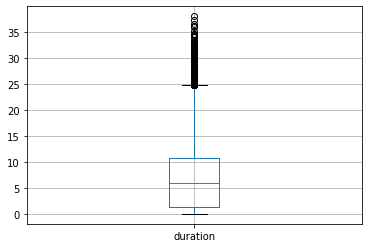

In [53]:
df_calls.boxplot(column="duration")

In [54]:
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [55]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [56]:
df_internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [57]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [58]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [59]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [60]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [61]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [62]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [63]:
print(f'Количество городов: {len(df_users["city"].unique())} шт.')
df_users['city'].unique()

Количество городов: 76 шт.


array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [64]:
print(f'Количество имен: {len(df_users["first_name"].unique())} шт.')
df_users['first_name'].unique()

Количество имен: 246 шт.


array(['Рафаил', 'Иван', 'Евгений', 'Белла', 'Татьяна', 'Афанасий',
       'Леонид', 'Юна', 'Рустэм', 'Василиса', 'Эдуард', 'Веселина',
       'Варлам', 'Борис', 'Яков', 'Рузана', 'Марица', 'Мария', 'Матвей',
       'Игнатий', 'Тала', 'Святослав', 'Людмила', 'Иулиан', 'Владислав',
       'Рустем', 'Алексей', 'Мариетта', 'Лаврентий', 'Инна', 'Лия',
       'Розалия', 'Анжелика', 'Изольда', 'Агнесса', 'Юрий', 'Михаил',
       'Константин', 'Марианна', 'Иннокентий', 'Джемма', 'Екатерина',
       'Милица', 'Лола', 'Габриель', 'Кристина', 'Павел', 'Ренальд',
       'Луиза', 'Радислав', 'Динара', 'Лукий', 'Глеб', 'Тамара',
       'Александр', 'Таира', 'Роза', 'Исак', 'Юзефа', 'Ким', 'Гордей',
       'Эльза', 'Гектор', 'Андрей', 'Рафаэль', 'Фёдор', 'Харитон',
       'Еремей', 'Всеволод', 'Софья', 'Авксентий', 'Виолетта', 'Ириней',
       'Гелена', 'Ксения', 'Вера', 'Вениамин', 'Вероника', 'Даниэла',
       'Алла', 'Элеонора', 'Аюна', 'Руслан', 'Онисим', 'Марта', 'Эльвира',
       'Габриэль', '

### Вывод

- df_calls - все заполнено, можно вытащить месяц из этого датасета, чтобы сделать таблицу расходов каждого клиента по месяцам. Для нулевых звонков я решила, что их буду убирать при анализе, т.к. вопрос стоит в том, что "сколько нужно минут в месяц", т.е. эти пропущенные звонки не играют роли, но при этом будут влиять на среднее значение и автоматически на дисперсию и стандартное отклонение. Предполагаю, что 0 минут это были пропущенные звонки.
- df_internet - пропусков нет. Лишнюю колонку убрала с помощью index_col. Предположительно она появилась при экспорте данных из базы, откуда ее вытащили. Нулевые значения я планирую убирать, как и в звонках. Думаю, что нулевые значения появились, когда пользователь заходил в браузер, но по какой-то причине не переходил на страницу, либо же настойка устройства мобильного запрещает некоторым приложениям использовать интернет-трафик в фоновом режиме, либо был исходящий трафик, но без входящего(скачиваний и переходов). Дату тоже нужно проработать, чтобы месяц вычленить.
- df_messages - пропусков нет, достать месяц.
- df_tariffs - эта таблица чисто в помощь нужна будет, здесь все отлично. Тип числовых данных исправлять не нужно.
- df_users - Здесь заполнено все, кроме колонки "churn_date", где указана дата прекращения пользования тарифом. Я не планирую заполнять ничем эту колонку. При осмотре городов пользователей ошибку я не выявила, нет обозначения населенных пунктов "село" или "город", что могло бы привести к дублям. По именам аналогично нет проблем.

## Шаг 2. Предобработка данных

- Приведите данные к нужным типам;
- Найдите и исправьте ошибки в данных;
- Сделать таблицы по затраченым звонкам, смс и интернету на каждого пользователя по месяцам 

#### Исправляю значения МБ в ГБ в таблице с тарифами

In [65]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [66]:
df_tariffs['mb_per_month_included'] = df_tariffs['mb_per_month_included'].replace(15360, 15)
df_tariffs['mb_per_month_included'] = df_tariffs['mb_per_month_included'].replace(30720, 30)

In [67]:
df_tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name']

In [68]:
df_tariffs.head()

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


#### Привожу в порядок таблицу со звонками абонентов

In [69]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

In [70]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


Округляю секунды в минуты, т.к. оператор всегда округляет и высчитывает излишки из целых чисел. Таким образом мы точно понимаем, что 0 минут, это 0 минут, а не 0,5 минут.

In [71]:
df_calls['duration'] = np.ceil(df_calls['duration'])

Я исключаю из дальнейшей работы звонки длительностью 0 минут, т.к. считаю, что это пропущенные звонки. Вопрос исслдедования стоит как "Сколько нужно минут в месяц?". Если это пропущенный звонок, то будет новая попытка дозвониться и при ответе будут просчитаны затраченные минуты. Если же я нули оставлю, то это может повлиять на среднее при дальнейших рассчетах.

In [72]:
good_calls = df_calls.query('duration != 0.0')
good_calls

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12
202603,1499_216,2018-10-18,19.0,1499,10
202604,1499_217,2018-11-10,11.0,1499,11
202605,1499_218,2018-10-06,5.0,1499,10


По вашей рекомендации составляю таблицу. Я хочу обработать каждую таблицу, привести к единому виду и затем соединить, чтобы у меня не было лишних колонок в последствии

In [73]:
user_min = good_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
user_min = user_min.astype('int64')
user_min

,user_id,month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3163,1498,10,247
3164,1499,9,70
3165,1499,10,449
3166,1499,11,612


#### Подготавливаю таблицу с показателями сессий абонентов

In [74]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

In [75]:
df_internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Округляем показатели интернет сессий, т.к. оператор это делает при рассчете о затраченных МБ и мы понимаем, где были затраты по трафику точно, а где 0 МБ

In [76]:
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])
df_internet

,id,mb_used,session_date,user_id,month
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,1053.0,2018-09-07,1000,9
2,1000_2,1198.0,2018-06-25,1000,6
3,1000_3,551.0,2018-08-22,1000,8
4,1000_4,303.0,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,319.0,2018-10-03,1499,10
149392,1499_153,491.0,2018-12-14,1499,12
149393,1499_154,0.0,2018-10-27,1499,10
149394,1499_155,1247.0,2018-11-26,1499,11


Я убираю из таблицы сессии в 0 МБ, т.к. это может повлиять на среднее значени в дальнейших рассчетах и как следствие на дисперсию со стандартным отклонением. Причины почему некоторые сессии равны 0 МБ:
- пользователь зашел в браузер, но по каким-то причинам не перешел на страницу
- был исходящий трафик, но не было входящего(скачиваний, переходов по страницам)
- приложениям на устройстве было запрещено использовать мобильный трафик в настройках устройств

Данные за 2018 год, это буквально 2 года назад. Объем мобильного трафика вырос за последнее десятилетие, многие приложения используют его для своей работы, а также само устройство для передачи данных о своей работе.

При любом из вариантов эти нули не должны участвовать в ответе на вопрос "Сколько нужно интернет-трафика в месяц?", потому что тут не было затрат трафика.

In [77]:
good_internet = df_internet.query('mb_used != 0.0')
good_internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,1053.0,2018-09-07,1000,9
2,1000_2,1198.0,2018-06-25,1000,6
3,1000_3,551.0,2018-08-22,1000,8
4,1000_4,303.0,2018-09-24,1000,9


In [78]:
users_gb = good_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
users_gb

,user_id,month,mb_used
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
...,...,...,...
3196,1498,10,20604.0
3197,1499,9,1848.0
3198,1499,10,17809.0
3199,1499,11,17984.0


Нужно округлить МБ перевести в ГБ, потому что лимиты и рассчет удобнее производить в ГБ. Округлю до 1 знака после запятой, чтобы было нагляднее.

In [79]:
users_gb['gb'] = round(users_gb['mb_used'] /1024, 1)
users_gb = users_gb.drop('mb_used', axis=1)
users_gb

,user_id,month,gb
0,1000,5,2.2
1,1000,6,22.7
2,1000,7,13.7
3,1000,8,13.7
4,1000,9,14.2
...,...,...,...
3196,1498,10,20.1
3197,1499,9,1.8
3198,1499,10,17.4
3199,1499,11,17.6


#### Подготавливаю таблицу с сообщениями

In [80]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [81]:
users_mess = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index()
users_mess.columns = ('user_id', 'month', 'mess')
users_mess

,user_id,month,mess
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Соединяю все таблицы, чтобы получить большую итоговую таблицу с необзодимыми данными и работать только с ней

In [82]:
user_all = user_min.merge(users_gb, on = ['user_id', 'month'], how='outer')
user_all = user_all.merge(users_mess, on =['user_id', 'month'], how='outer')
user_all = user_all.merge(df_users[['user_id', 'tariff']], on = 'user_id')
user_all = user_all.merge(df_tariffs, right_on = 'tariff_name', left_on='tariff')
user_all

,user_id,month,duration,gb,mess,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,159.0,2.2,22.0,ultra,1000,30,3000,1950,150,1,1,ultra
1,1000,6,172.0,22.7,60.0,ultra,1000,30,3000,1950,150,1,1,ultra
2,1000,7,340.0,13.7,75.0,ultra,1000,30,3000,1950,150,1,1,ultra
3,1000,8,408.0,13.7,81.0,ultra,1000,30,3000,1950,150,1,1,ultra
4,1000,9,466.0,14.2,57.0,ultra,1000,30,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,NaN,10.8,17.0,smart,50,15,500,550,200,3,3,smart
3210,1489,9,NaN,16.8,32.0,smart,50,15,500,550,200,3,3,smart
3211,1489,10,NaN,19.1,21.0,smart,50,15,500,550,200,3,3,smart
3212,1489,11,NaN,17.1,20.0,smart,50,15,500,550,200,3,3,smart


Создаю функцию для рассчетов помесячной выручки для каждого пользователя

In [83]:
def revenue(df):
    mins = df['duration']
    gb = df['gb']
    mess = df['mess']
    abon = df['rub_monthly_fee']
    total_mins = 0
    total_gb = 0
    total_mess = 0
    total = 0
    
    if (mins - df['minutes_included']) > 0:
        delta_min = (mins - df['minutes_included']) * df['rub_per_minute']
        total_mins += delta_min
    else:
        delta_min = 0
        total_mins += delta_min
        
    if (mess-df['messages_included']) > 0:
        delta_mess = (mess - df['messages_included']) * df['rub_per_message']
        total_mins += delta_mess
    else:
        delta_mess = 0
        total_mins += delta_mess
        
    if (gb-df['gb_per_month_included']) > 0:
        delta_gb = ((gb - df['gb_per_month_included'])) * df['rub_per_gb']
        total_mins += delta_gb
    else:
        delta_gb = 0
        total_mins += delta_gb
        
    total = total_mins + total_mess + total_gb + abon
    
    return total   

In [84]:
user_all['montly_revenue'] = user_all.apply(revenue, axis=1)
user_all

,user_id,month,duration,gb,mess,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,montly_revenue
0,1000,5,159.0,2.2,22.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0
1,1000,6,172.0,22.7,60.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0
2,1000,7,340.0,13.7,75.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0
3,1000,8,408.0,13.7,81.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0
4,1000,9,466.0,14.2,57.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,NaN,10.8,17.0,smart,50,15,500,550,200,3,3,smart,550.0
3210,1489,9,NaN,16.8,32.0,smart,50,15,500,550,200,3,3,smart,910.0
3211,1489,10,NaN,19.1,21.0,smart,50,15,500,550,200,3,3,smart,1370.0
3212,1489,11,NaN,17.1,20.0,smart,50,15,500,550,200,3,3,smart,970.0


### Вывод

Все таблички с количеством затреченных минут, смс, мб и помесячной оплатой я составила отдельно, потом соединяла. В итоге у меня получились таблицы:

- users_min. Таблица с количеством потраченных минут на звонки в месяц на каждого абонента.
- users_gb. Таблица с количеством потраченных ГБ в месяц на каждого абонента.
- users_mess. Таблица с количеством потраченных смс в месяц на каждого абонента.
- user_all. Таблица со всеми минутами, ГБ и сообщениями по месяцам по каждому абоненту с учетом тарифа.
- rev_all. Таблица с просчитанной прибылью по кажому месяцу по каждому абоненту.

## Шаг 3. Анализ данных

In [85]:
df_mean_var_std = user_all.pivot_table(index='tariff', values=['duration', 'gb', 'mess'], aggfunc=['mean', 'var', 'std'])
df_mean_var_std.columns = ['mean_mim', 'mean_gb', 'mean_mess', 'var_mim', 'var_gb', 'var_mess', 'std_mim', 'std_gb', 'std_mess']
df_mean_var_std

,mean_mim,mean_gb,mean_mess,var_mim,var_gb,var_mess,std_mim,std_gb,std_mess
tariff,,,,,,,,,
smart,419.440342,15.862371,38.716441,35718.128534,32.748233,717.594201,188.992403,5.722607,26.787949
ultra,547.755016,19.244764,61.161006,93338.428291,94.146381,2109.659183,305.513385,9.702906,45.931026


##### Гистограмма плотностей по израсходованным минутам по месяцам 

Для удобства построения графиков разделю итоговую таблицу по тарифам

In [86]:
df_smart = user_all.query('tariff == "smart"')
df_ultra = user_all.query('tariff == "ultra"')

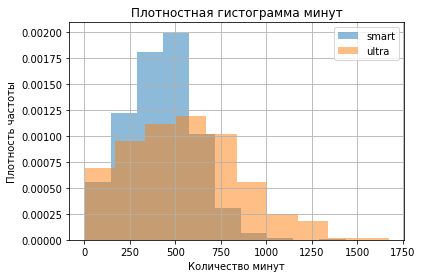

In [87]:
ax = df_smart['duration'].plot(kind='hist', grid=True, density=True, alpha=0.5, title='Плотностная гистограмма минут')
ax = df_ultra['duration'].plot(kind='hist', grid=True, density=True, alpha=0.5)
ax.legend(["smart", "ultra"])
plt.ylabel("Плотность частоты")
plt.xlabel("Количество минут")
plt.show()

##### Гистограмма плотностей по израсходованным сообщениям по месяцам 

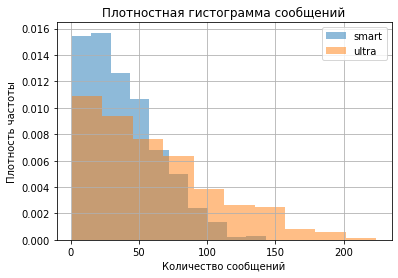

In [88]:
ax = df_smart['mess'].plot(kind='hist', grid=True, density=True, alpha=0.5, title='Плотностная гистограмма сообщений')
ax = df_ultra['mess'].plot(kind='hist', grid=True, density=True, alpha=0.5)
ax.legend(["smart", "ultra"])
plt.ylabel("Плотность частоты")
plt.xlabel("Количество сообщений")
plt.show()

##### Гистограмма плотностей по израсходованным ГБ по месяцам 

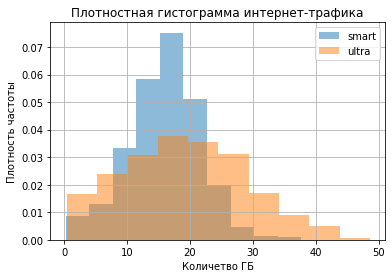

In [89]:
ax = df_smart['gb'].plot(kind='hist', grid=True, density=True, alpha=0.5, title='Плотностная гистограмма интернет-трафика')
ax = df_ultra['gb'].plot(kind='hist', grid=True, density=True, alpha=0.5)
ax.legend(["smart", "ultra"])
plt.ylabel("Плотность частоты")
plt.xlabel("Количетво ГБ")
plt.show()

##### Гистограмма плотностей по выручке по месяцам

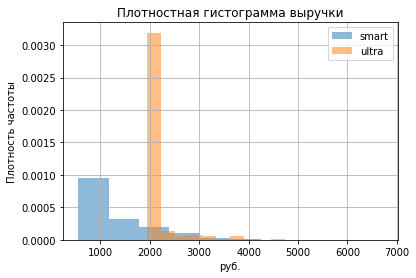

In [90]:
ax = df_smart['montly_revenue'].plot(kind='hist', grid=True, density=True, alpha=0.5, title='Плотностная гистограмма выручки')
ax = df_ultra['montly_revenue'].plot(kind='hist', grid=True, density=True, alpha=0.5)
ax.legend(["smart", "ultra"])
plt.ylabel("Плотность частоты")
plt.xlabel("руб.")
plt.show()

### Вывод

По потраченным минутам и ГБ распределение по обоим тарифам выглядит нормальным. Тариф ultra немного "шире", но это из-за того, что им пользуются меньше абонентов, чем smart. По сообщениям и на графике по выручке распределение больше похоже на распределение Пуассона.
По выручке можно сказать, что чаще всего оплата идет строго по тарифу в обоих случаях. Но в тарифе smart график скошен вправо и получается, что случаев переплат больше, чем в тарифе ultra.

Какое количество услуг нужно для абоненту в месяц? По таблице со средними значениями и отклонением получаем:
- Smart
    - По минутам: 300-600 минут
    - По сообщениям: не более 50 шт.
    - По ГБ: 12-18 ГБ
- Ultra
    - По минутам: 300-750 минут
    - По сообщениям: не более 50 шт.
    - По ГБ: 15-30 ГБ    

## Шаг 4. Проверка гипотез

Гипотеза №1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Нулевая гипотеза: Средняя выручка тарифа Smart равна средней выручке тарифа Ultra.

Альтернативная гипотеза: Средняя выручка тарифа Smart НЕ равна средней выручке тарифа Ultra. 

Гипотеза №2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза: Средняя выручка Москвы равна средней выручке регионов.

Альтернативная гипотеза:  Средняя выручка Москвы НЕ равна средней выручке других регионов.

Нужно отделить выручку по тарифам. Сделаем таблички. Добавлю город и тариф каждому абоненту. И заменю города отличные от Москвы, на "Регион"

In [91]:
user_all = user_all.merge(df_users[['user_id', 'city']], on='user_id')

In [92]:
user_all.loc[user_all['city'] != 'Москва', 'city'] = 'Регион'

In [93]:
user_all.head()

,user_id,month,duration,gb,mess,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,montly_revenue,city
0,1000,5,159.0,2.2,22.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0,Регион
1,1000,6,172.0,22.7,60.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0,Регион
2,1000,7,340.0,13.7,75.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0,Регион
3,1000,8,408.0,13.7,81.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0,Регион
4,1000,9,466.0,14.2,57.0,ultra,1000,30,3000,1950,150,1,1,ultra,1950.0,Регион


In [94]:
alpha = .05

results_tariff = st.ttest_ind(
    user_all.loc[user_all['tariff'] =='smart', 'montly_revenue'], 
    user_all.loc[user_all['tariff'] =='ultra', 'montly_revenue'], equal_var=False)
print('p-значение по тарифам:', results_tariff.pvalue)

if (results_tariff.pvalue < alpha):
    print("Отвергаем нулевую гипотезу по тарифам")
else:
    print("Не получилось отвергнуть нулевую гипотезу по тарифам")
    
print('--------------------------------------------------')   

results_city = st.ttest_ind(
    user_all.loc[user_all['city'] == 'Регион', 'montly_revenue'], 
    user_all.loc[user_all['city'] == 'Москва', 'montly_revenue'])
print('p-значение по тарифам:', results_city.pvalue)

if (results_city.pvalue < alpha):
    print("Отвергаем нулевую гипотезу по городам")
else:
    print("Не получилось отвергнуть нулевую гипотезу по городам")

p-значение по тарифам: 8.149930554954492e-296
Отвергаем нулевую гипотезу по тарифам
--------------------------------------------------
p-значение по тарифам: 0.47749132832089203
Не получилось отвергнуть нулевую гипотезу по городам


### Вывод

Проверки гипотез показали, что скорее всего среднее значение тарифов различаются, а средняя выручка пользователей из Москвы не отличается от средней выручки из других регионов. Я выбрала использовать st.ttest_ind, т.к. у нас сравниваются 2 средних значения друг с другом. Зависимости между ними нет. 

### Шаг 5. Общий вывод

- Тариф Smart. Пользователей этого тарифа больше, он более доступен по цене. Но в месяц пользователям нужно больше минут и ГБ, чем предоставляет тариф. Это дает дополнительный доход. Количество смс в рамках тарифа достаточно. Он больше подходит для пользователей с небольшим потреблением услуг
- Тариф Ultra. Здесь пользователей меньше по количеству и они больше разбросаны. Минут и сообщений пользователях хватает с избытком, перерасходов по лимитам нет. Но по количесву затраченных ГБ есть перерасход. Главная ценность тарифа в количестве ГБ, потому что в другом тарифе его существенно меньше и мы видим перерасход по этой услуге в обоих случаях.

Гипотеза о том, что средние значения выручки тарифов не отвергаем и можно предположить, что тариф Smart более выгодный.
Как возможные пути действия с тарифами: 
1. Добавить ГБ в тариф Smart и поднять абонентскую плату.
2. Добавить ГБ в тариф Ultra и не меняя абонентскую плату.
Таким образом можно привлечь пользователей кому мало предложенных ГБ в Ultra, а в тариф Smart придут пользователи, которым не нужно так много ГБ, как в Ultra.